# Project iFood CRM - Data Advanced Analytics Business Case

![Teste](https://www.cora.com.br/blog/wp-content/uploads/elementor/thumbs/Imagem-Ifood-red-1-pqpti8fbo93e9dbvljmi9hm48xg4073mrqaq7898cg.png)

iFood is the lead food delivery app in Brazil, present in over a thousand cities.
Keeping a high customer engagement is key for growing and consolidating the company’s
position as the market leader.

Data Analysts working within the data team are constantly challenged to provide insights and
value to the company through open scope projects. This case intends to simulate that.
In this case, you are presented a sample dataset, that mocks metainformation on the customer
and on iFood campaign interactions with that customer.

It is your challenge to understand the data, find business opportunities & insights and to propose
any data driven action to optimize the campaigns results & generate value to the company.
This case aims to evaluate your Data skills and knowledge for two possible roles:

- Data Analyst Business:
    - Perform robust exploratory analysis, rich with business insights & data driven proposals
to add value to the company and have strong communication skills to influence the
decision making
- Data Advanced Analytics
    - Perform robust exploratory analysis, using advanced analytics tools and statistical
methods to generate data products to optimize business results (predictive & clustering
models, for example)


### About the dataset
The data set contains socio-demographic and firmographic features about 2.240 customers who
were contacted. Additionally, it contains a flag for those customers who responded the campaign,
by buying the product

### Goals of the Project

- Explore the data - you need to provide the marketing team a better understanding of the characteristics features of respodents;
- At least 3 important insights;
- Model a customer segmentation that can increase the campaign profit;
- Create a predictive model to maximize the profit of the next marketing campaign;
- Power Point to present the results.

### Deliverable
- Power Point with Results;
- API that can be used by the business and marketing team.

### Data Source
https://github.com/ifood/ifood-data-business-analyst-test

### Solution Planning

Since the business case is composed by 3 parts, I will split the problem in 3 different notebooks to be well organized and structured. The goal of the data analysis notebook will be analyze the provided dataset and understand the data. Also,  it is necessary to create some hypothesis, validate it using exploratory data analysis and extract some actionable insights. The second part is using some methods to create cluster of clients according to the profile and use it to create some recommendations for the marketing campaign. It should increase the profit, since we are aiming specific clients. The last part will be the predictive model, joining the results generated by the clustering modelization, we can predict if the client will accept the next offer and then calculate the business impact based on the inputs of the dataset.

#### 1. Planning of Data Analysis
- Business understanding and context
- Describe Data
- Hypothesis Creation
- Feature Engineering
- Filtering Variables
- Exploratory Data Analysis

#### 2. Planning of Clustering
- Data Preparation
- Feature Selection
- Modeling Cluster
- Cluster Analysis
- Recommendations


#### 3. Planning of Predictive Model
- Data Preparation
- Feature Selection
- Machine Learning Modeling
- Hyper parameters Fine-Tunning
- Evaluation
- Business Impact


### Data Dictionary

![Data](images/metadata-table.PNG)

## 0.0 Imports

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import shap
plt.rcParams['axes.axisbelow'] = True

### 0.1 Helper Functions

In [241]:
def descriptive_analysis(numerical_df):
    # Function that calculate all the statistics measures for the dataset
    # Central tendency - Mean, median
    ct1 = pd.DataFrame(numerical_df.apply(np.mean)).T
    ct2 = pd.DataFrame(numerical_df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(numerical_df.apply(np.std)).T
    d2 = pd.DataFrame(numerical_df.apply(min)).T
    d3 = pd.DataFrame(numerical_df.apply(max)).T
    d4 = pd.DataFrame(numerical_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(numerical_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(numerical_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
    m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

    return m

In [242]:
def camel_to_snake(s):
    # Function that converts camel style to snake style
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [243]:
def capping_outliers(df, col):
    quantile_10 = df[col].quantile(0.10)
    quantile_90 = df[col].quantile(0.90)
    
    df[col] = np.where(df[col] < quantile_10, quantile_10, df[col])
    df[col] = np.where(df[col] > quantile_90, quantile_90, df[col])
    
    return df


### 0.2 Loading Data

In [244]:
df0 = pd.read_csv('../data/ml_project1_data.csv')

In [245]:
df0.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


### 0.3 Rename Columns

In [246]:
old_columns = ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
               'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
               'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
               'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
               'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
               'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

lower_case = lambda x: x.lower()

new_columns = list(map(lower_case, old_columns))

df0.columns = new_columns

## 1.0 Data Description

In [247]:
df1 = df0.copy()

### 1.1 Data Dimensions

In [248]:
print('Number of examples:', df1.shape[0])
print('Number of features:', df1.shape[1])

Number of examples: 2240
Number of features: 29


### 1.2 Data Type

In [249]:
df1.dtypes

id                       int64
year_birth               int64
education               object
marital_status          object
income                 float64
kidhome                  int64
teenhome                 int64
dt_customer             object
recency                  int64
mntwines                 int64
mntfruits                int64
mntmeatproducts          int64
mntfishproducts          int64
mntsweetproducts         int64
mntgoldprods             int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
z_costcontact            int64
z_revenue                int64
response                 int64
dtype: object

All the data types seems coherent except dt_customer, which is a datetime. Let's change it.

In [250]:
df1['dt_customer'] = pd.to_datetime(df1['dt_customer'])

### 1.3 Missing Values

In [251]:
(df1.isna().sum() / len(df1))*100

id                     0.000000
year_birth             0.000000
education              0.000000
marital_status         0.000000
income                 1.071429
kidhome                0.000000
teenhome               0.000000
dt_customer            0.000000
recency                0.000000
mntwines               0.000000
mntfruits              0.000000
mntmeatproducts        0.000000
mntfishproducts        0.000000
mntsweetproducts       0.000000
mntgoldprods           0.000000
numdealspurchases      0.000000
numwebpurchases        0.000000
numcatalogpurchases    0.000000
numstorepurchases      0.000000
numwebvisitsmonth      0.000000
acceptedcmp3           0.000000
acceptedcmp4           0.000000
acceptedcmp5           0.000000
acceptedcmp1           0.000000
acceptedcmp2           0.000000
complain               0.000000
z_costcontact          0.000000
z_revenue              0.000000
response               0.000000
dtype: float64

Only 1% of the income is null. Let's make some treatment later since the value is not high.

### 1.4 Balance of Response

In [252]:
df1['response'].value_counts(normalize = True)*100

0    85.089286
1    14.910714
Name: response, dtype: float64

Only 14% of the dataset has answered the last campaign. Later we can compare with the other campaigns efficiency.

### 1.5 Descriptive Statistics

In [253]:
num_vars = df1.select_dtypes(include = ['int64', 'float64'])
cat_vars = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

#### 1.5.1 Numerical Attributes

In [254]:
stat = descriptive_analysis(num_vars)
stat

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,id,5592.159821,5458.5,3245.937415,0.0,11191.0,11191.0,0.039832,-1.190028
1,year_birth,1968.805804,1970.0,11.981394,1893.0,1996.0,103.0,-0.349944,0.717464
2,income,52247.251354,NaN,25167.396174,1730.0,666666.0,664936.0,6.763487,159.636700
3,kidhome,0.444196,0.0,0.538278,0.0,2.0,2.0,0.635288,-0.779661
4,teenhome,0.506250,0.0,0.544417,0.0,2.0,2.0,0.407115,-0.986235
5,recency,49.109375,49.0,28.955987,0.0,99.0,99.0,-0.001987,-1.201897
6,mntwines,303.935714,173.5,336.522251,0.0,1493.0,1493.0,1.175771,0.598744
7,mntfruits,26.302232,8.0,39.764555,0.0,199.0,199.0,2.102063,4.050976
8,mntmeatproducts,166.950000,67.0,225.664984,0.0,1725.0,1725.0,2.083233,5.516724
9,mntfishproducts,37.525446,12.0,54.616784,0.0,259.0,259.0,1.919769,3.096461


- year_birth shows some insconsistency, since the minimum year is 1893, which leads to an age of more then 100 years. Also, the average age is about 44 years (assuming the dataset is from 2014).
- income of $1730 (yearly) is unrealistic for a family, maybe this is a inconsistency or students that lives alone but receive from parents. 
- kidhome and teenhome is limited to 2 childrens.
- The number of days since the last purchase (recency) is about 49 days, on average.
- The mean amount spent with wines and meat is greater than the other products (more expensive).
- People use to buy, on average, almost the same frequency on web or at the store.
- The sucess rate of the past campaigns (from 1 to 5) is about 7% except for the second one, which is 1.3%.
- The complain rate is less than 1%.
- z_costcontact and z_revenue does not have any information.
- The sucess rate of the last campaign (7th or response) is about 15%.

#### 1.5.2 Categorical Attributes

In [255]:
cat_vars['education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [256]:
cat_vars['marital_status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [257]:
cat_vars['marital_status'].value_counts(normalize=True)*100

Married     38.571429
Together    25.892857
Single      21.428571
Divorced    10.357143
Widow        3.437500
Alone        0.133929
Absurd       0.089286
YOLO         0.089286
Name: marital_status, dtype: float64

Education and Marital Status has low cardinality, so it is possible to treat them as dummies or encodings. However, there are some weird categories in martital status, such as: Alone, Absurd and YOLO. In this case, we can drop them for the dataset or we can transform these 3 categories in "Single". Since they represented less than 1%, I will drop it.

In [258]:
df1['marital_status'] = df1.apply(lambda x: 'Alone' if (x['marital_status'] == 'Absurd' or x['marital_status'] == 'YOLO') else x['marital_status'], axis = 1)

## 2.0 Hypothesis 

In [260]:
df2 = df1.copy()

### 2.2 Hypothesis

- The new users arrive with the same distribution along the year?
- Which campaign has the best performance?
- There are differences between the best and the worst campaign? 
- What are the negative and positive characteristics of users that accept the marketing campaigns (2 and 6)?
- What channel brings more amount of money?
- What are the negative and positive characteristics of web sales?


## 3.0 Feature Engineering

In [261]:
# Creating the number of depedents at home
df2['dependent_number'] = df2['kidhome'] + df2['teenhome']

In [262]:
# Creating the total amount spent by each customer
df2['amount_spent'] = df2['mntmeatproducts'] + df2['mntwines'] + df2['mntfruits'] + df2['mntsweetproducts'] + df2['mntfishproducts']

In [263]:
# Creating the number of accepted campaigns 
df2['accepted_campaigns'] = df2['acceptedcmp1'] + df2['acceptedcmp2'] + df2['acceptedcmp3'] + df2['acceptedcmp4'] + df2['acceptedcmp5'] + df2['response']

In [264]:
# Creating the loyalty variable - days
df2['loyalty_days'] = df2['dt_customer'].max() - df2['dt_customer']
df2['loyalty_days'] = df2['loyalty_days'] //  np.timedelta64(1, 'D')

In [266]:
# Creating the loyalty variable - convert to month
df2['loyalty_months'] = df2['loyalty_days'] / 30

In [267]:
# Creating the loyalty variable - convert to years
df2['loyalty_years'] = df2['loyalty_days'] / 365

In [265]:
# Creating variable related to first access 
df2['dayofweek_sub'] = df2['dt_customer'].dt.day_of_week
df2['month_sub'] = df2['dt_customer'].dt.month

In [268]:
# Creating the amount spent per month 
df2['amount_spent_month'] = df2.apply(lambda x:  x['amount_spent'] / x['loyalty_months'] if x['loyalty_months'] > 1 else x['amount_spent'], axis = 1)

In [269]:
# Creating the total number of purchases
df2['total_purchases'] = df2['numdealspurchases'] + df2['numwebpurchases'] + df2['numcatalogpurchases'] + df2['numstorepurchases']

In [270]:
# Creating the total number of purchasese by each month
df2['purchases_month'] = df2['total_purchases'] / df2['loyalty_months']

In [271]:
# Create the age of the customer
df2['age'] = df2['dt_customer'].dt.year.max() - df2['year_birth']

In [272]:
# Creating percentage spent on different products
df2['percentage_spent_wines'] = df2['mntwines'] / df2['amount_spent']
df2['percentage_spent_fruits'] = df2['mntfruits'] / df2['amount_spent']
df2['percentage_spent_meat'] = df2['mntmeatproducts'] / df2['amount_spent']
df2['percentage_spent_fish'] = df2['mntfishproducts'] / df2['amount_spent']
df2['percentage_spent_sweet'] = df2['mntsweetproducts'] / df2['amount_spent']
df2['percentage_spent_gold'] = df2['mntgoldprods'] / df2['amount_spent']

In [273]:
# Creating percentage purchases on different channel types
df2['percentage_type_deals'] = df2['numdealspurchases'] / df2['total_purchases']
df2['percentage_type_web'] = df2['numwebpurchases'] / df2['total_purchases']
df2['percentage_type_catalog'] = df2['numcatalogpurchases'] / df2['total_purchases']
df2['percentage_type_store'] = df2['numstorepurchases'] / df2['total_purchases']

In [274]:
# Creating the number of purchases in web per month
df2['web_purchases_month'] = df2['numwebpurchases'] / (np.floor(df2['loyalty_months']) + 1)

## 3.0 Filtering Variables

In [276]:
df3 = df2.copy()

z_costcontact and z_revenue does not have any information, then I will delete them.

In [277]:
df3 = df3.drop(['z_costcontact', 'z_revenue'], axis = 1)

## 4.0 Exploratory Data Analysis (EDA)

In [278]:
df4 = df3.copy()

In [279]:
num_vars = df4.select_dtypes(include = ['int64', 'float64'])
cat_vars = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [280]:
# Transforming some numerical variables to categories for visualization
cat_vars['teenhome'] = num_vars['teenhome']
cat_vars['kidhome'] = num_vars['kidhome']
cat_vars['dependent_number'] = num_vars['dependent_number']
cat_vars['acceptedcmp1'] = num_vars['acceptedcmp1']
cat_vars['acceptedcmp2'] = num_vars['acceptedcmp2']
cat_vars['acceptedcmp3'] = num_vars['acceptedcmp3']
cat_vars['acceptedcmp4'] = num_vars['acceptedcmp4']
cat_vars['acceptedcmp5'] = num_vars['acceptedcmp5']
cat_vars['response'] = num_vars['response']


### 4.1 Univariate Analysis

Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` vari

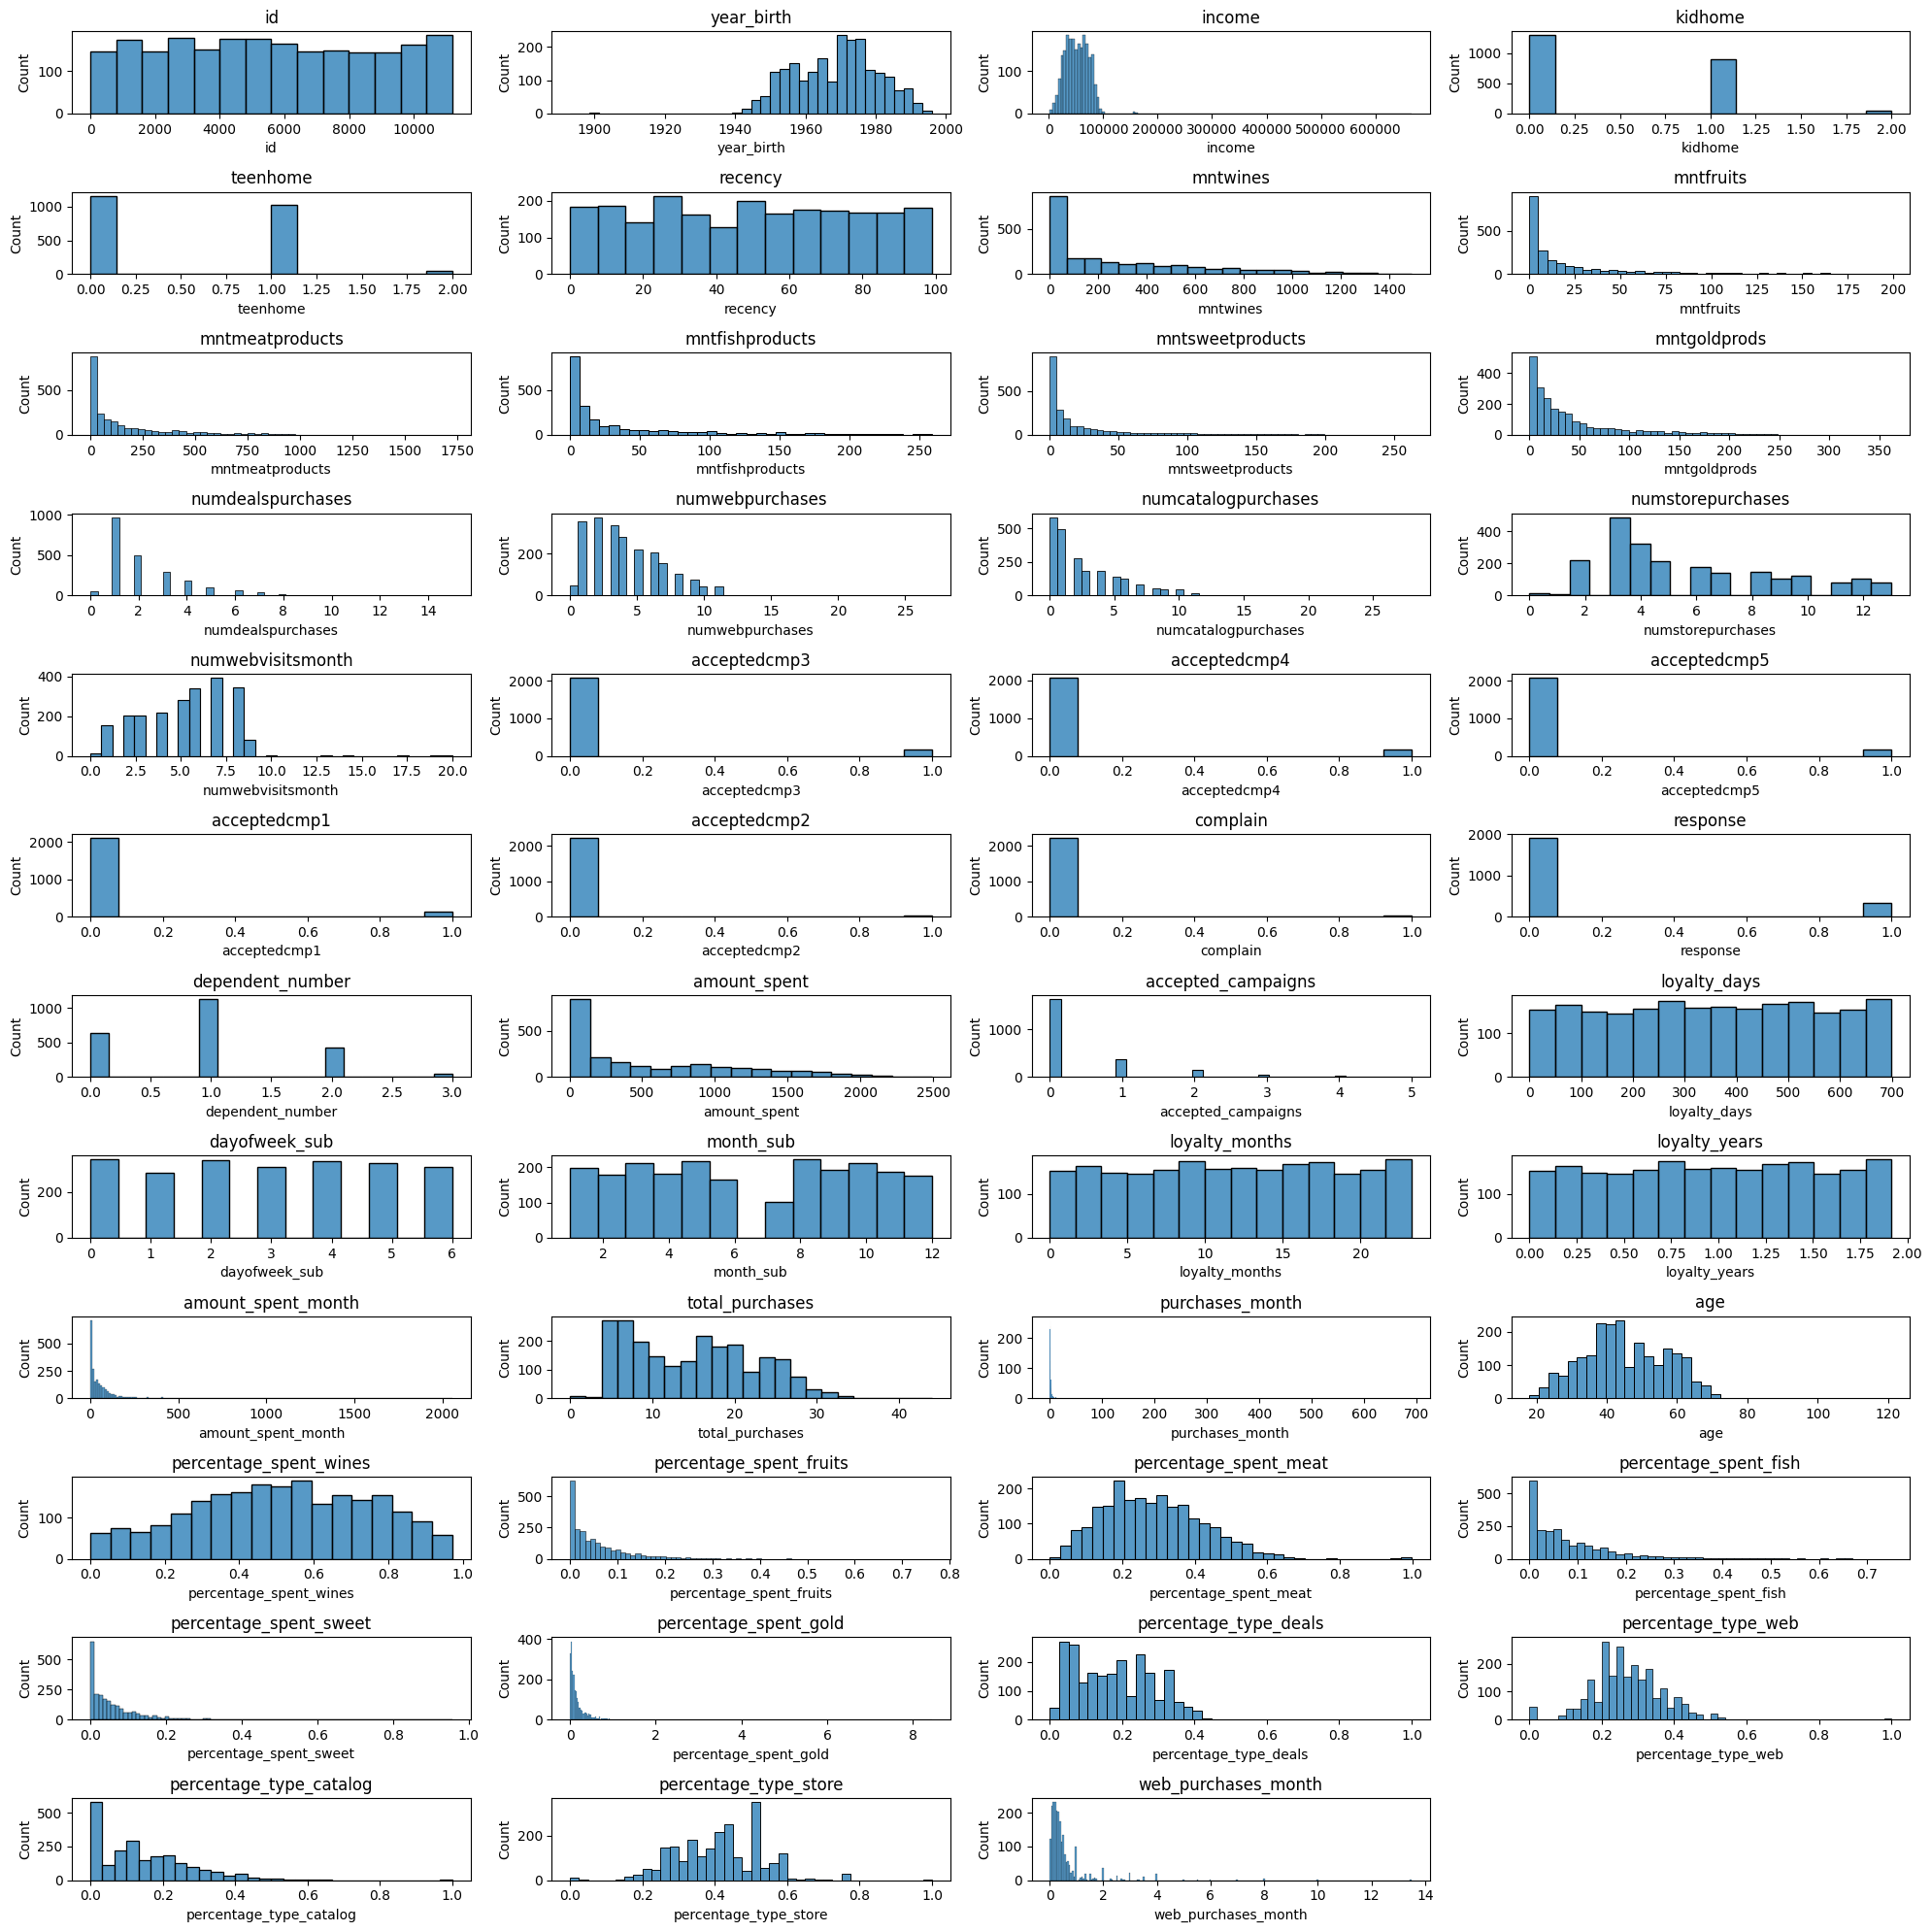

In [281]:
plt.figure(1, figsize = (20,20))
for i, col in enumerate(num_vars.columns):
    plt.subplot(12, 4, i+1)
    sns.histplot(x = num_vars[col], palette=sns.color_palette('Reds'))
    plt.title(col)
    plt.tight_layout()

- Features that depends on time is uniform (loyalty and recency)
- Features that represent the amount spent follows a exponential distribution, which means that there are more people that spend small amount of money and a few people that spend large amounts of money.

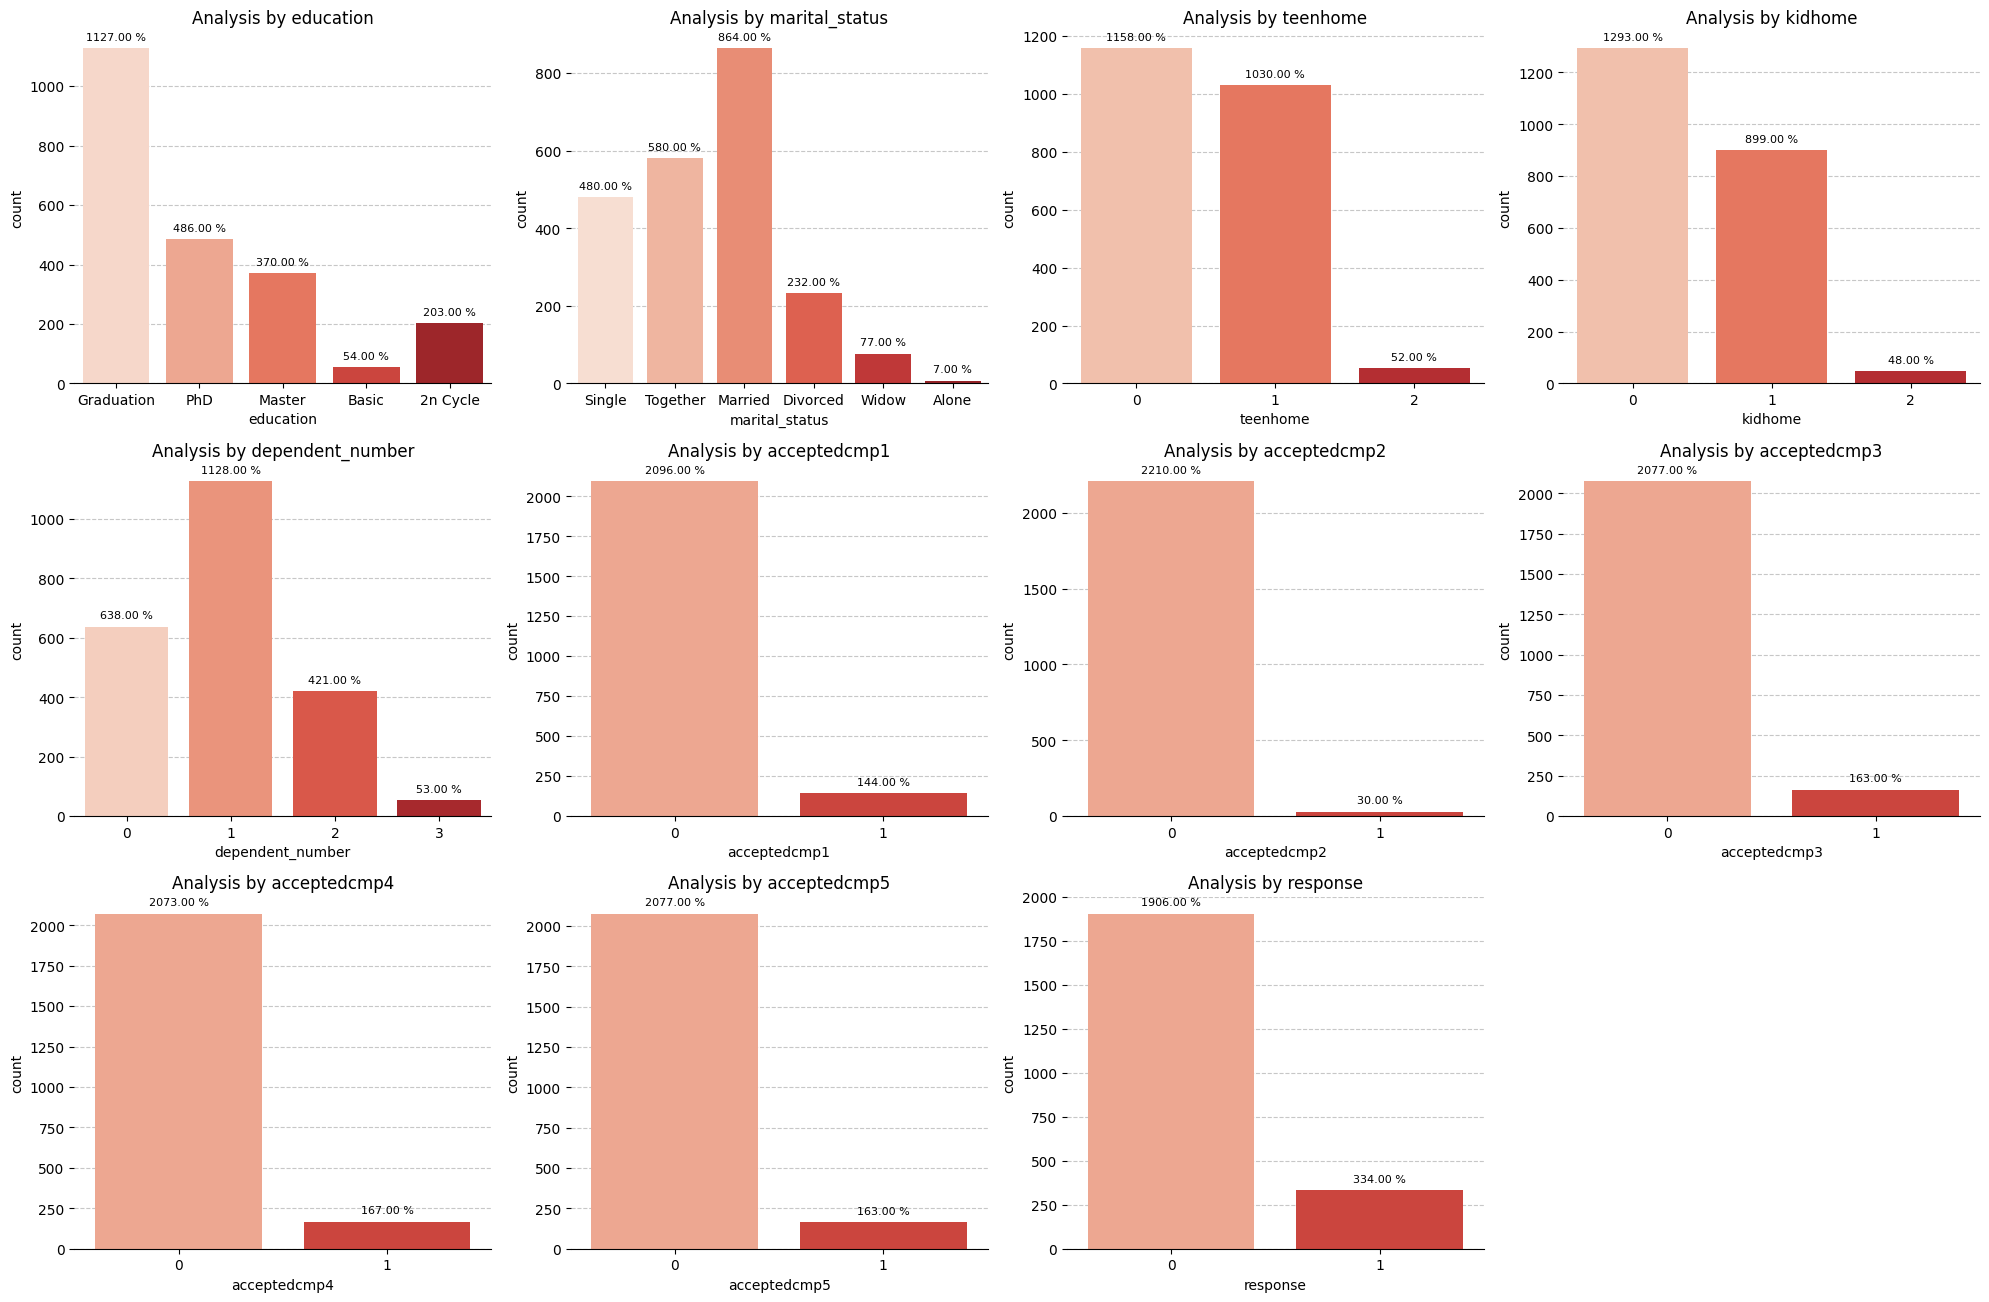

In [282]:
plt.figure(1, figsize = (20,30))
for i, col in enumerate(cat_vars.columns):
    plt.subplot(7, 4, i+1)
    ax = sns.countplot(x = cat_vars[col], palette=sns.color_palette('Reds', cat_vars[col].nunique()))
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(False)

    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in ax.patches:
    
    
        ax.annotate(f"{format(bar.get_height(), '.2f')} %",
                    (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                    size=8, xytext=(0, 8),
                    textcoords='offset points')

    plt.title('Analysis by ' + col)
    plt.tight_layout()

- Most people are graduated and are in couple (married or together);
- Most people have at least 1 dependent at home (kid or teenager);
- As observed before, the acceptation rate of each campaign is ~ 7% (despite cmp2 and the last one, which is ~ 15%). Maybe it is interesting to analyze both of them that has a different behavior.

### 4.2 Bivariate Analysis

### Analyzing the seasonality of new users

**The new users arrive with the same distribution along the year?**

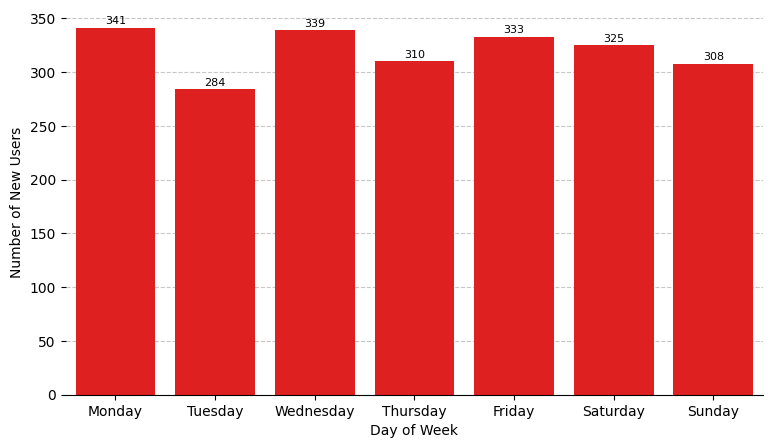

In [283]:
plt.figure(1, figsize = (9, 5))
ax = sns.countplot(x = df4['dayofweek_sub'], color = 'r')
plt.xlabel('Day of Week')
plt.ylabel('Number of New Users')
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#ax.set_xticks(range(len(day_names)))
ax.set_xticklabels(day_names)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)


for bar in ax.patches:
   
 
    ax.annotate(f"{int(bar.get_height())}",
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 5),
                   textcoords='offset points')

There is no day that is significant more important than others regarding the new users. It is well distributed and we can't find any pattern on this data.

In [284]:
df_highlight = df4['month_sub'].value_counts().reset_index()
df_highlight['color'] = df_highlight['month_sub'].apply(lambda x: 'r' if x > 170 else 'y')
df_highlight = df_highlight.sort_values('index', ascending = False)

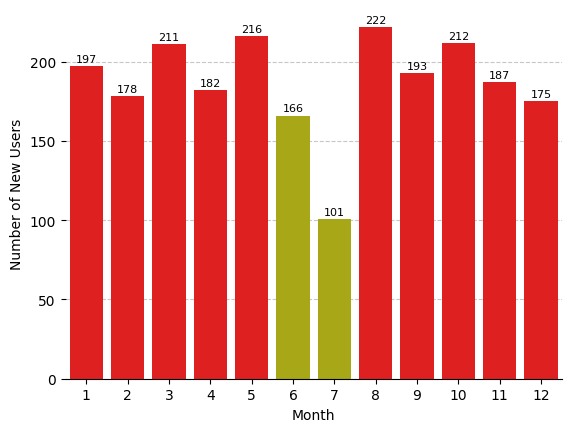

In [285]:
ax = sns.barplot(x = 'index', y = 'month_sub', palette=df_highlight['color'], data = df_highlight)
plt.xlabel('Month')
plt.ylabel('Number of New Users')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in ax.patches:
   
 
    ax.annotate(f"{int(bar.get_height())}",
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 5),
                   textcoords='offset points')

The new users are distributed along the year, however, in July there is a abrupt loss when comparing to the other months. Then, this can be an opportunity to explore.


### Analzying behavior of people that accepted any campaign and who never accepted a campaign

In [286]:
users_no_cmp = df4[(df4['acceptedcmp1'] != 1) & (df4['acceptedcmp2'] != 1) & (df4['acceptedcmp3'] != 1) & (df4['acceptedcmp4'] != 1) & (df4['acceptedcmp5'] != 1) & (df4['response'] != 1)].index
users_cmp = df4[~df4.index.isin(users_no_cmp)].index



In [287]:
df4.loc[users_no_cmp, 'no_cmp'] = 1
df4.loc[df4.index.isin(users_cmp), 'no_cmp'] = 0

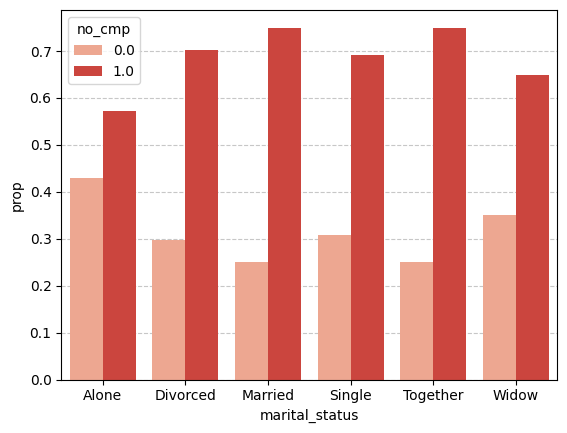

In [288]:
df_marital = df4.groupby('marital_status')['no_cmp'].value_counts(normalize=True).reset_index(name='prop')
sns.barplot(data=df_marital,x='marital_status',y='prop',palette = sns.color_palette('Reds', 2), hue='no_cmp')

plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

People that lives alone or are single/divorced usually accept more marketing campaigns than others.

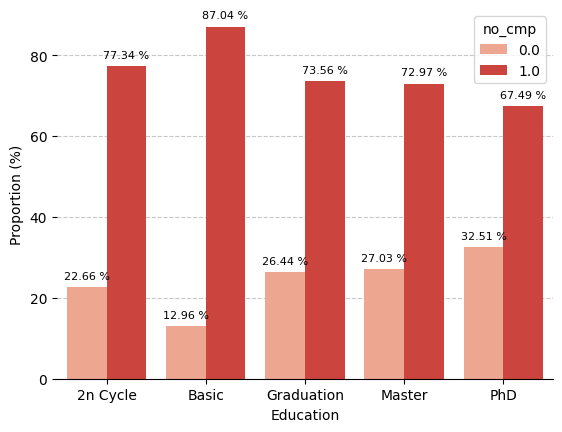

In [289]:
df_educ = df4.groupby('education')['no_cmp'].value_counts(normalize=True).mul(100).reset_index(name='prop')
ax = sns.barplot(data=df_educ,x='education',y='prop',palette = sns.color_palette('Reds', 2), hue='no_cmp')
for bar in ax.patches:
   
 
    ax.annotate(f"{format(bar.get_height(), '.2f')} %",
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel('Education')
plt.ylabel('Proportion (%)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

People who have more education, tends to accept more campaigns.

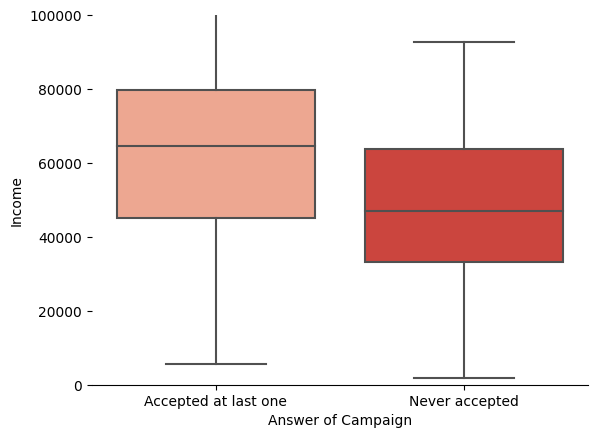

In [290]:
ax = sns.boxplot(x = 'no_cmp', y = 'income', palette = sns.color_palette('Reds', 2), data = df4)
ax.set_ylim([0, 100000])
ax.set_xticklabels(['Accepted at last one', 'Never accepted'])
plt.xlabel('Answer of Campaign')
plt.ylabel('Income')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

People that accept campaigns usually have more income.

Text(0.5, 0, 'Answer of Campaign')

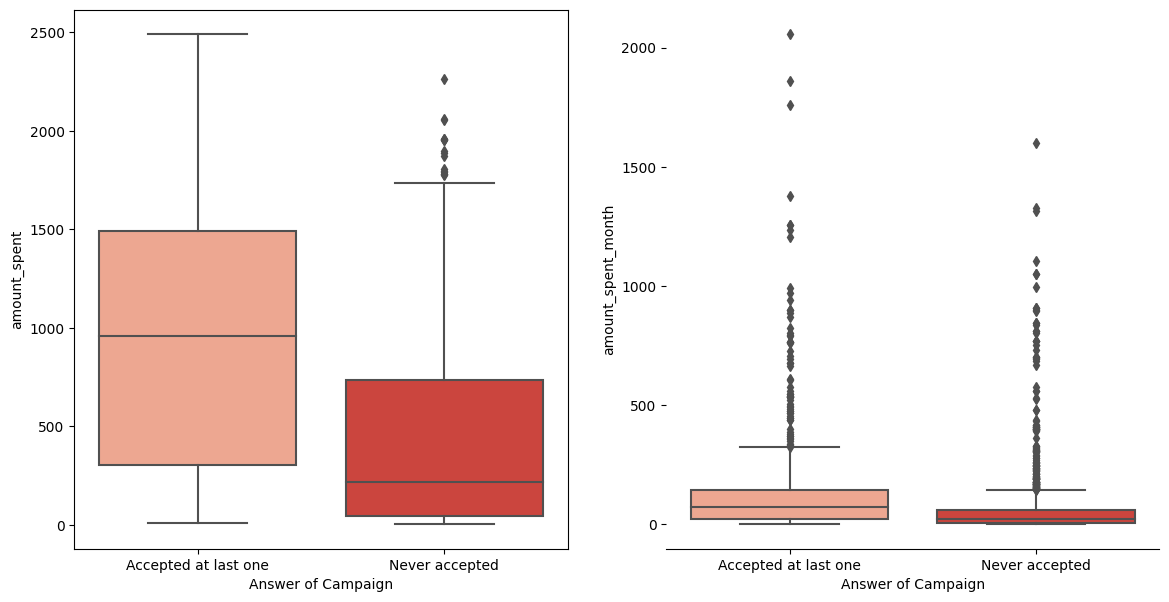

In [291]:
plt.figure(1, figsize = (14,7))
plt.subplot(1, 2, 1)
ax = sns.boxplot(x = 'no_cmp', y = 'amount_spent', palette = sns.color_palette('Reds', 2), data = df4)
ax.set_xticklabels(['Accepted at last one', 'Never accepted'])
plt.xlabel('Answer of Campaign')
plt.subplot(1, 2, 2)
ax = sns.boxplot(x = 'no_cmp', y = 'amount_spent_month', palette = sns.color_palette('Reds', 2), data = df4)
ax.set_xticklabels(['Accepted at last one', 'Never accepted'])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

plt.xlabel('Answer of Campaign')
#plt.ylabel('Income')

Text(0.5, 0, 'Answer of Campaign')

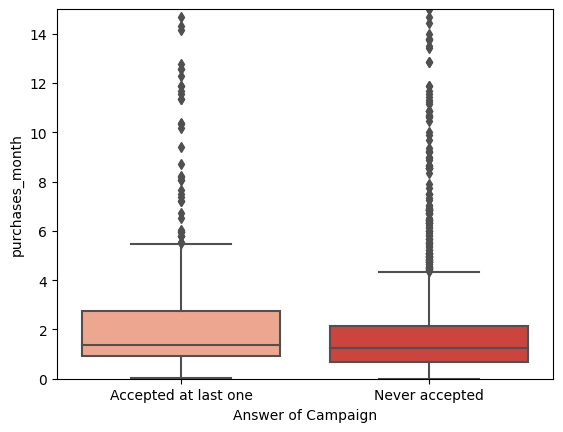

In [292]:

ax = sns.boxplot(x = 'no_cmp', y = 'purchases_month', palette = sns.color_palette('Reds', 2), data = df4)
ax.set_xticklabels(['Accepted at last one', 'Never accepted'])
plt.ylim([0, 15])
plt.xlabel('Answer of Campaign')

People that accepted campaigns usually spend more, but they usually don't purchase more per month.

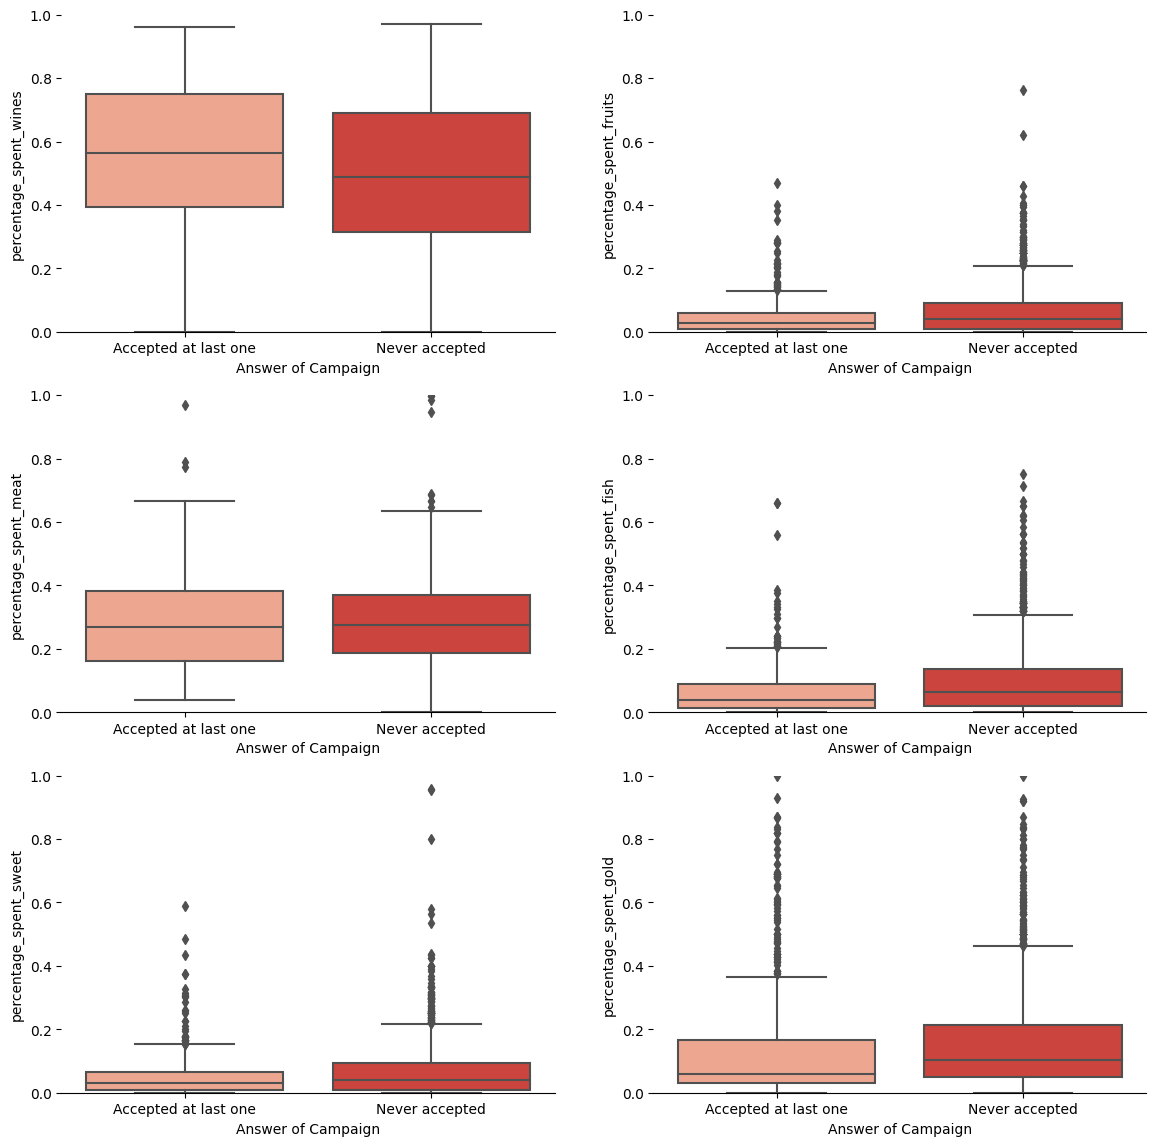

In [293]:
cols_to_analyze = ['percentage_spent_wines','percentage_spent_fruits', 'percentage_spent_meat','percentage_spent_fish', 'percentage_spent_sweet', 'percentage_spent_gold']

plt.figure(1, figsize = (14,14))
for i, col in enumerate(cols_to_analyze):
    plt.subplot(3, 2, i+1)
    ax = sns.boxplot(x = 'no_cmp', y = col, palette = sns.color_palette('Reds', 2), data = df4)
    ax.set_xticklabels(['Accepted at last one', 'Never accepted'])
    plt.ylim([0, 1])
    plt.xlabel('Answer of Campaign')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(False)


It's only possible to say that marketing campaigns attract more people that spend money on wines, the others have a similar behavior.

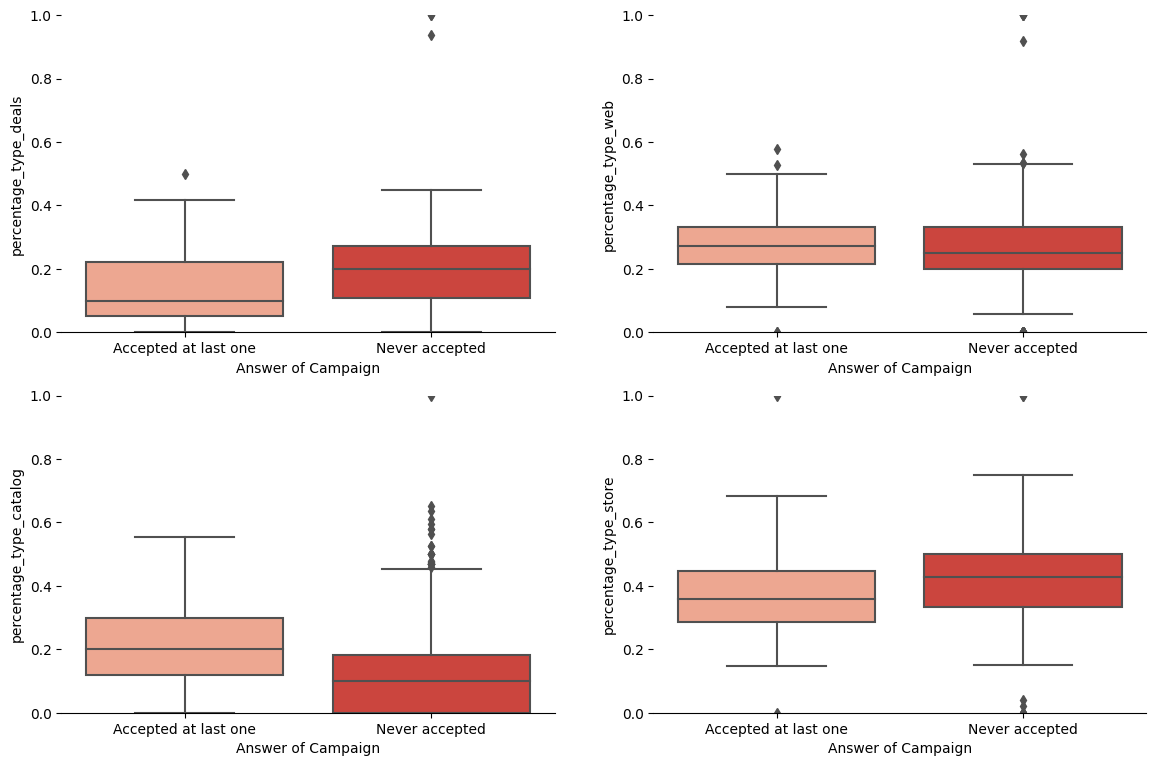

In [294]:
cols_to_analyze = ['percentage_type_deals', 'percentage_type_web','percentage_type_catalog', 'percentage_type_store']

plt.figure(1, figsize = (14,14))
for i, col in enumerate(cols_to_analyze):
    plt.subplot(3, 2, i+1)
    ax = sns.boxplot(x = 'no_cmp', y = col, palette = sns.color_palette('Reds', 2), data = df4)
    ax.set_xticklabels(['Accepted at last one', 'Never accepted'])
    plt.ylim([0, 1])
    ax.set_xlabel('Answer of Campaign')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(False)


- On average, people who never accepted a campaign usually buy more with discounts than who accepted at least one campaign, which is weird. Discounts without campaigns are better?
- Who buy on catalog tends to accept a marketing campaign
- Who buy on store usually don't accept a marketing campaign


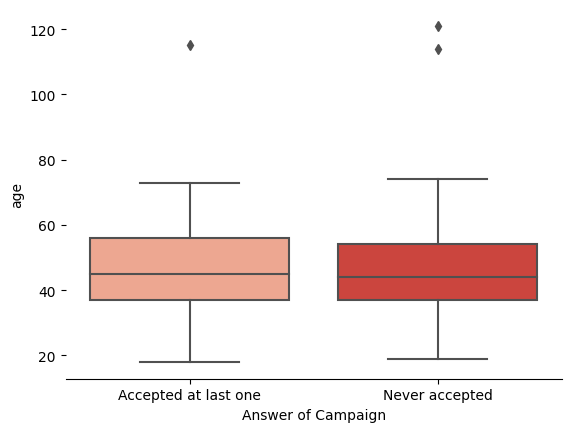

In [295]:

ax = sns.boxplot(x = 'no_cmp', y = 'age', palette = sns.color_palette('Reds', 2), data = df4)
ax.set_xticklabels(['Accepted at last one', 'Never accepted'])
ax.set_xlabel('Answer of Campaign')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

There is no difference regarding age.

### Analyzing similarity of customers that accepted each campaign

**Which campaign has the best performance?**

In [296]:
df_conversion = pd.DataFrame()
conversions = []
campaigns = ['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'response']
for col in campaigns:
    conversions.append(df4[col].value_counts(normalize=True)[1]*100)

df_conversion = pd.DataFrame({'campaign': campaigns,
                              'conversion': conversions })


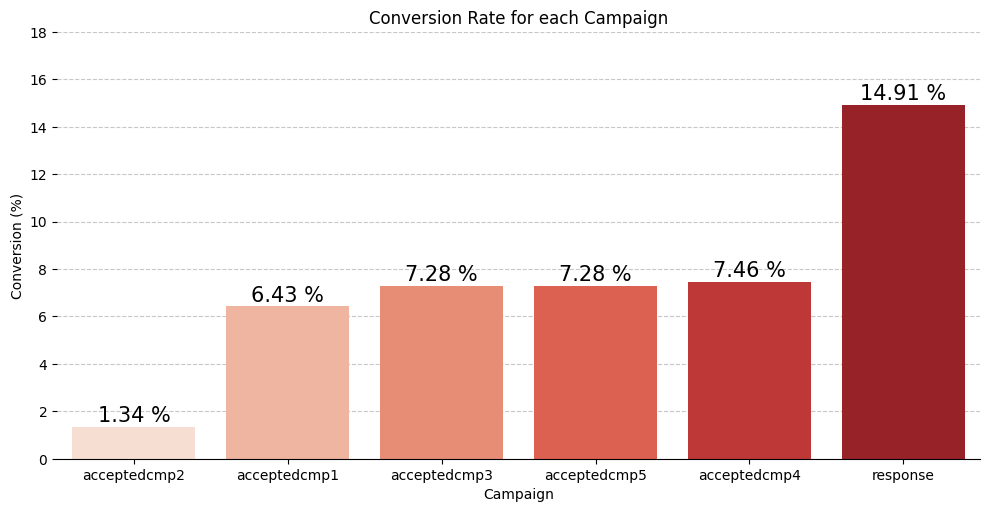

In [297]:
plt.figure(1, figsize = (10,5))
ax = sns.barplot(x = 'campaign', y = 'conversion', palette = sns.color_palette('Reds'), data = df_conversion.sort_values('conversion', ascending = True))
plt.tight_layout()
plt.xlabel('Campaign')
plt.ylabel('Conversion (%)')
plt.ylim([0, 18])
plt.title('Conversion Rate for each Campaign')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

plt.rc('axes', axisbelow=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Iterating over the bars one-by-one
for bar in ax.patches:
   
 
    ax.annotate(f"{format(bar.get_height(), '.2f')} %",
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

**There are differences between the best and the worst campaign?**

In [298]:
# Create a group for who accepted 2 and 6 to compare with others
df_cmp6 = df4[df4['response'] == 1].copy()
df_cmp2 = df4[df4['acceptedcmp2'] == 1].copy()
df_others = df4[(df4['response'] != 1) & (df4['acceptedcmp2'] != 1)]


In [299]:
var_to_compare = ['amount_spent_month', 'loyalty_days', 'income', 'percentage_spent_meat', 'percentage_spent_gold', 'percentage_spent_sweet', 'percentage_spent_fish', 'percentage_spent_fruits', 'percentage_spent_wines', 'percentage_type_store', 'percentage_type_web', 'percentage_type_catalog', 'percentage_type_deals', 'purchases_month', 'dependent_number']
df_cmp6 = df_cmp6[var_to_compare].select_dtypes(include = ['int64' , 'float64']).median().reset_index().rename(columns = {0:'cmp6'})
df_cmp6['others'] = df_others[var_to_compare].select_dtypes(include = ['int64' , 'float64']).median().values
df_cmp6['Diff'] = 100*(df_cmp6['cmp6'] - df_cmp6['others'])/df_cmp6['others']

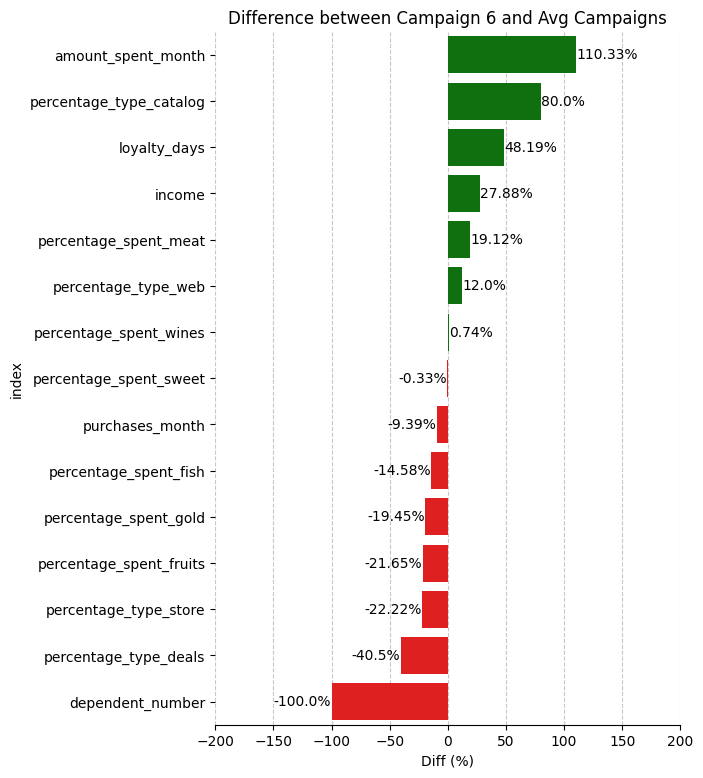

In [300]:
df_cmp6 = df_cmp6.sort_values('Diff', ascending=False)
df_cmp6['color'] = 'green'
df_cmp6.loc[df_cmp6['Diff'] < 0, 'color'] = 'red'
plt.figure(1, figsize = (6,9))
sns.barplot(y = 'index', x = 'Diff', palette = df_cmp6['color'], data = df_cmp6)
plt.title('Difference between Campaign 6 and Avg Campaigns')
plt.xlabel('Diff (%)')
plt.xlim([-200, 200])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

plt.rc('axes', axisbelow=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i in range(len(df_cmp6)):
    if df_cmp6.iloc[i]['Diff'] < 0:
        plt.text(x = df_cmp6.iloc[i]['Diff'] - 0.2, y = i, s = str(round(df_cmp6.iloc[i]['Diff'],2)) + '%', va = 'center', ha = 'right')
    else:
        plt.text(x = df_cmp6.iloc[i]['Diff'] + 0.2, y = i, s = str(round(df_cmp6.iloc[i]['Diff'], 2)) + '%', va = 'center', ha = 'left')

- The customers that answer last campaign spent 110% more than the customers that also answers the others campaigns.
- Customers that answer last campaign buy 80% more than the avg from other campaigns.
- Longer customers accepted more the campaign 6 than the average.
- The income of people who accepted the last campaign is 27% higher than the avg from other campaigns.
- The campaign 6 attracted more people who spent money on meat.
- The campaign has attracted 12% more people from internet.

In [301]:
var_to_compare = ['amount_spent_month', 'loyalty_days', 'income', 'percentage_spent_meat', 'percentage_spent_gold', 'percentage_spent_sweet', 'percentage_spent_fish', 'percentage_spent_fruits', 'percentage_spent_wines', 'percentage_type_store', 'percentage_type_web', 'percentage_type_catalog', 'percentage_type_deals', 'purchases_month', 'dependent_number']
# Take the mean of variables from campaign 2
df_cmp2 = df_cmp2[var_to_compare].select_dtypes(include = ['int64' , 'float64']).mean().reset_index().rename(columns = {0:'cmp2'})
# Take the mean of the other campaigns (excluding 2 and 6)
df_cmp2['others'] = df_others[var_to_compare].select_dtypes(include = ['int64' , 'float64']).mean().values
# Calculate the relative different related to the other campaigns
df_cmp2['Diff'] = 100*(df_cmp2['cmp2'] - df_cmp2['others'])/df_cmp2['others']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


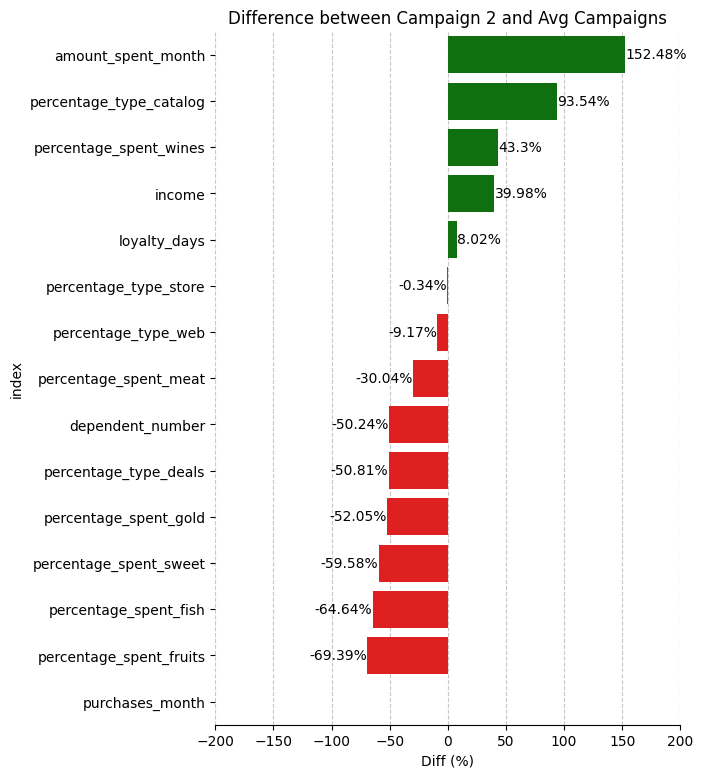

In [302]:
df_cmp2 = df_cmp2.sort_values('Diff', ascending=False)
df_cmp2['color'] = 'green'
df_cmp2.loc[df_cmp2['Diff'] < 0, 'color'] = 'red'
plt.figure(1, figsize = (6,9))

sns.barplot(y = 'index', x = 'Diff', palette = df_cmp2['color'], data = df_cmp2)
plt.title('Difference between Campaign 2 and Avg Campaigns')
plt.xlabel('Diff (%)')
plt.xlim([-200, 200])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

plt.rc('axes', axisbelow=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i in range(len(df_cmp2)):
    if df_cmp2.iloc[i]['Diff'] < 0:
        plt.text(x = df_cmp2.iloc[i]['Diff'] - 0.2, y = i, s = str(round(df_cmp2.iloc[i]['Diff'],2)) + '%', va = 'center', ha = 'right')
    else:
        plt.text(x = df_cmp2.iloc[i]['Diff'] + 0.2, y = i, s = str(round(df_cmp2.iloc[i]['Diff'], 2)) + '%', va = 'center', ha = 'left')

In [303]:
df_cmp2.sort_values('Diff', ascending=False)

,index,cmp2,others,Diff,color
0,amount_spent_month,203.566705,8.062651e+01,152.481108,green
11,percentage_type_catalog,0.248695,1.284995e-01,93.537585,green
8,percentage_spent_wines,0.729817,5.092952e-01,43.299420,green
2,income,71054.833333,5.076110e+04,39.978901,green
1,loyalty_days,364.100000,3.370538e+02,8.024298,green
9,percentage_type_store,0.419692,4.211179e-01,-0.338583,red
10,percentage_type_web,0.240097,2.643378e-01,-9.170461,red
3,percentage_spent_meat,0.194947,2.786721e-01,-30.044460,red
14,dependent_number,0.500000,1.004747e+00,-50.236220,red
12,percentage_type_deals,0.091516,1.860448e-01,-50.809557,red


- Campaign 2 has attracted people that spent more per month, around 152% when compared to the avg from other campaigns.
- The campaign has attracted people from the catalog, 93% more than the avg.
- People attracted from the campaign 2 was on wines, 43% more than the avg of other campaigns.
- Also, the income is 39% higher than the avg of other campaigns.

### Analyzing what make people accepted campaign 2 and 6

Analyzing both campaigns, it is possible to see what are the behaviors of customers that accepted both campaigns. To do so, we are analyzing the SHAP values of a classifier, which is useful to see if the impact is positive or negative.

The SHAP (SHapley Additive exPlanations) is a method of model interpretability based on the game theory, and it can explain any black-box models. It allows global (feature importance) and local (per observation) interpretability that can calculate the shapley values from the tree classifiers. In marketing area, it has been used to understand the impact of different features on the customer's likelihood to respond to an offer. Using this information, it is possible to see which variable can affect more the target and prioritize or avoid it to improve the conversion of the marketing campaign.

**What are the negative and positive characteristics of users that accept the marketing campaigns? (2 and 6)**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


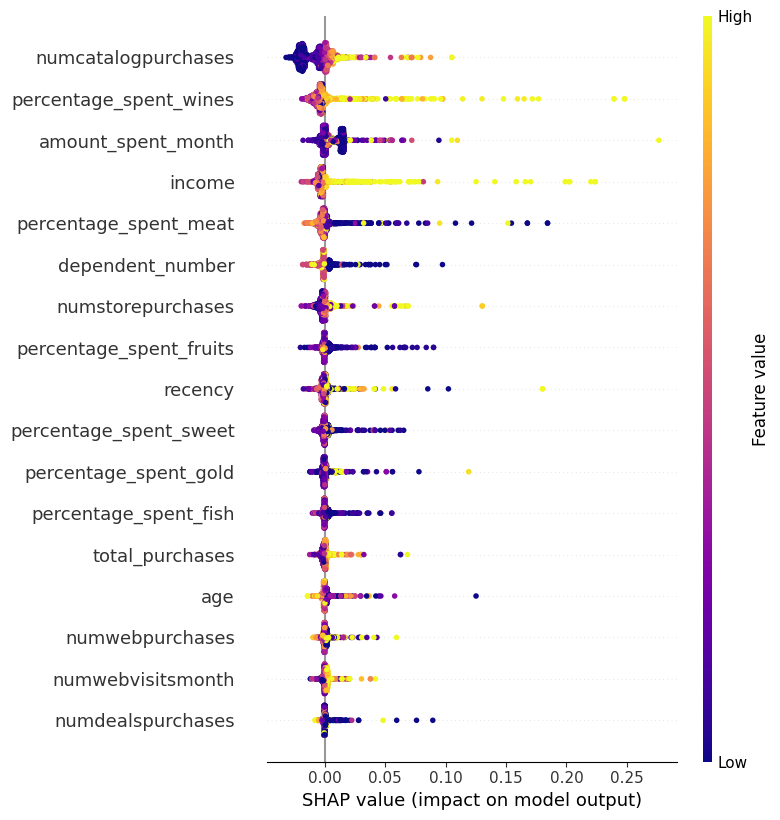

In [304]:
# Choose the campaign to explain
campaign = 'acceptedcmp2'

# Choose the features
features = ['income', 'dependent_number', 'amount_spent_month', 'recency', 'percentage_spent_wines', 'percentage_spent_fruits', 'percentage_spent_meat', 'percentage_spent_sweet', 'percentage_spent_gold', 'percentage_spent_fish', 'numwebpurchases', 'numdealspurchases', 'numcatalogpurchases', 'numstorepurchases', 'total_purchases', 'age', 'numwebvisitsmonth']
# Split only in train because the idea is not prediction, it's purely to understand the variables
df_rf = df4.copy().dropna()
X_train = df_rf[features]
y_train = df_rf[campaign]

# Run the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Run the explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values[1], X_train, cmap = "plasma")


- People that buy a lot from catalog tend to accept campaign 2.
- People that spend a lot on wines tend to accept campaign 2.
- People  that spend less per month tend to accept campaign 2.
- People with high income tend to accept campaign 2.
- People that spend less on meat tend to accept campaign 2.
- People that spend more on the store tend to accept campaign 2.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


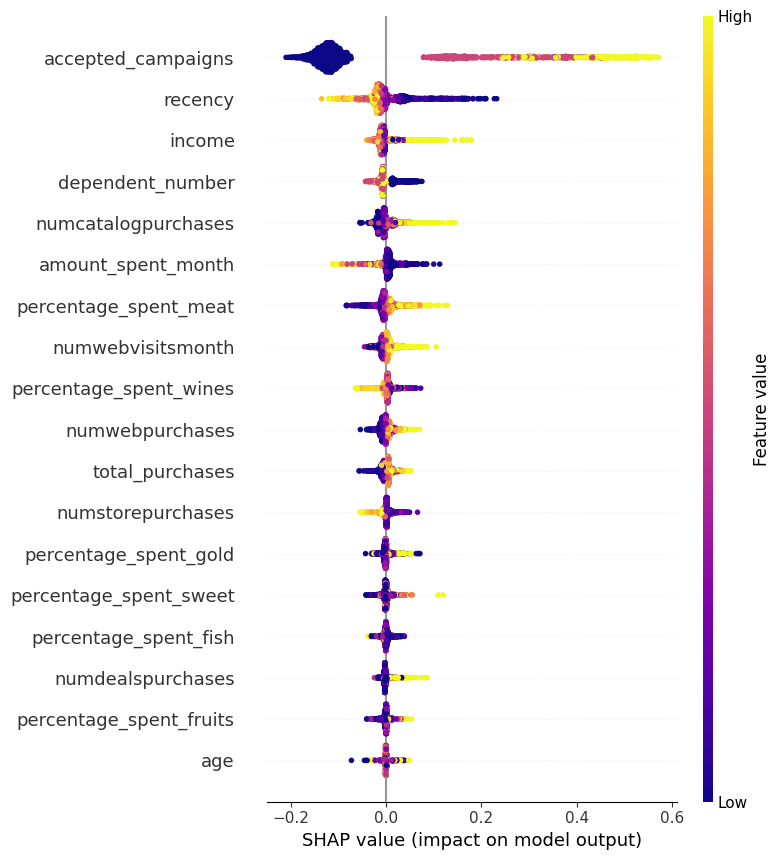

In [305]:
campaign = 'response'

features = ['income', 'dependent_number', 'amount_spent_month', 'accepted_campaigns', 'recency', 'percentage_spent_wines', 'percentage_spent_fruits', 'percentage_spent_meat', 'percentage_spent_sweet', 'percentage_spent_gold', 'percentage_spent_fish', 'numwebpurchases', 'numdealspurchases', 'numcatalogpurchases', 'numstorepurchases', 'total_purchases', 'age', 'numwebvisitsmonth']
df_rf = df4.copy().dropna()
X_train = df_rf[features]
y_train = df_rf[campaign]

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values[1], X_train, cmap = "plasma")

- People that accepted more campaigns (sum) tend to accept more campaign 6.
- People that spend less per month tend to accept more campaign 6.
- People that spend more on meat tend to accept more campaign 6.
- People that spend more on catalog tend to accept more campaign 6.
- Web features has more impact on campaign 6 than campaign 2, which shows an evolution on this channel.


Summarizing:
- numcatalogpurchases HIGH IMPACT FOR 2, HIGH IMPACT FOR 6
- pct_spent_wines HIGH IMPACT FOR 2, LOW IMPACT FOR 6 => AVOID PEOPLE THAT SPEND ON WINE
- income HIGH IMPACT FOR 2, HIGH IMPACT FOR 6 
- amonth_spent_month HIGH IMPACT FOR 2, LOW IMPACT FOR 6 => AVOID PEOPLE THAT SPENT A LOT PER MONTH
- pct_spent_meat LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE THAT SPEND ON MEAT
- numstorepurchases HIGH IMPACT FOR 2, LOW IMPACT FOR 6 => AVOID PEOPLE WHO BUY FROM STORES
- pct_spent_fruits LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE WHO SPENT MORE ON FRUITS
- pct_spent_sweat LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE WHO SPENT MORE ON SWEAT
- numwebpurchases LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE WHO SPENT MORE ON WEB
- pct_spent_fish LOW IMPACT FOR 2, LOW IMPACT FOR 6
- dependent number LOW IMPACT FOR 2, LOW IMPACT FOR 6
- pct_spent_gold LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE WHO SPENT MORE ON GOLD PRODS



### Analyzing Channels and Customer's Channel Types

**What channel brings more amount of money?**

<AxesSubplot: >

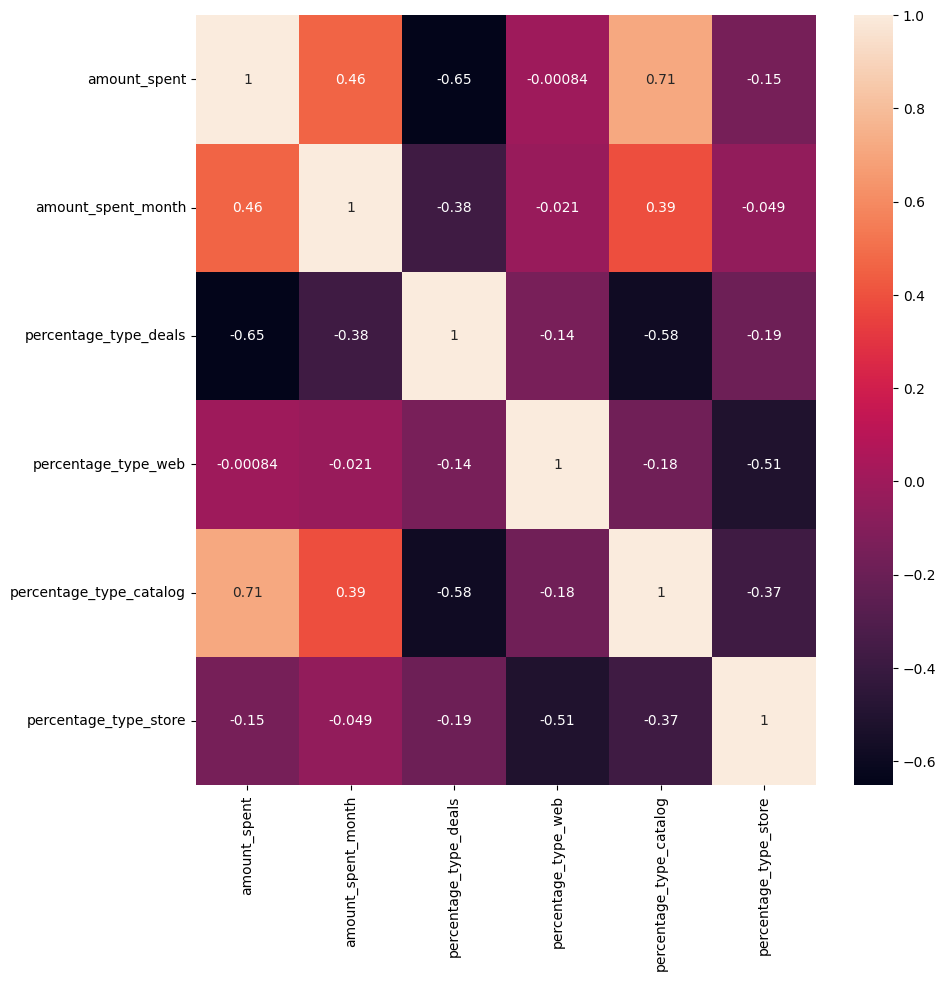

In [320]:
plt.figure(1, figsize=(10,10))
sns.heatmap(df4[['amount_spent', 'amount_spent_month', 'percentage_type_deals', 'percentage_type_web', 'percentage_type_catalog', 'percentage_type_store']].corr(), annot = True)

It is not possible to measure how much it is spent in each type, but it is possible to see that the customers with the most correlation with amount spent is from catalog, followed by deals. Online and Amount spent is almost zero, which can indicate that web is not rentable.

### Analyzing the Behavior of Online Customers

<AxesSubplot: >

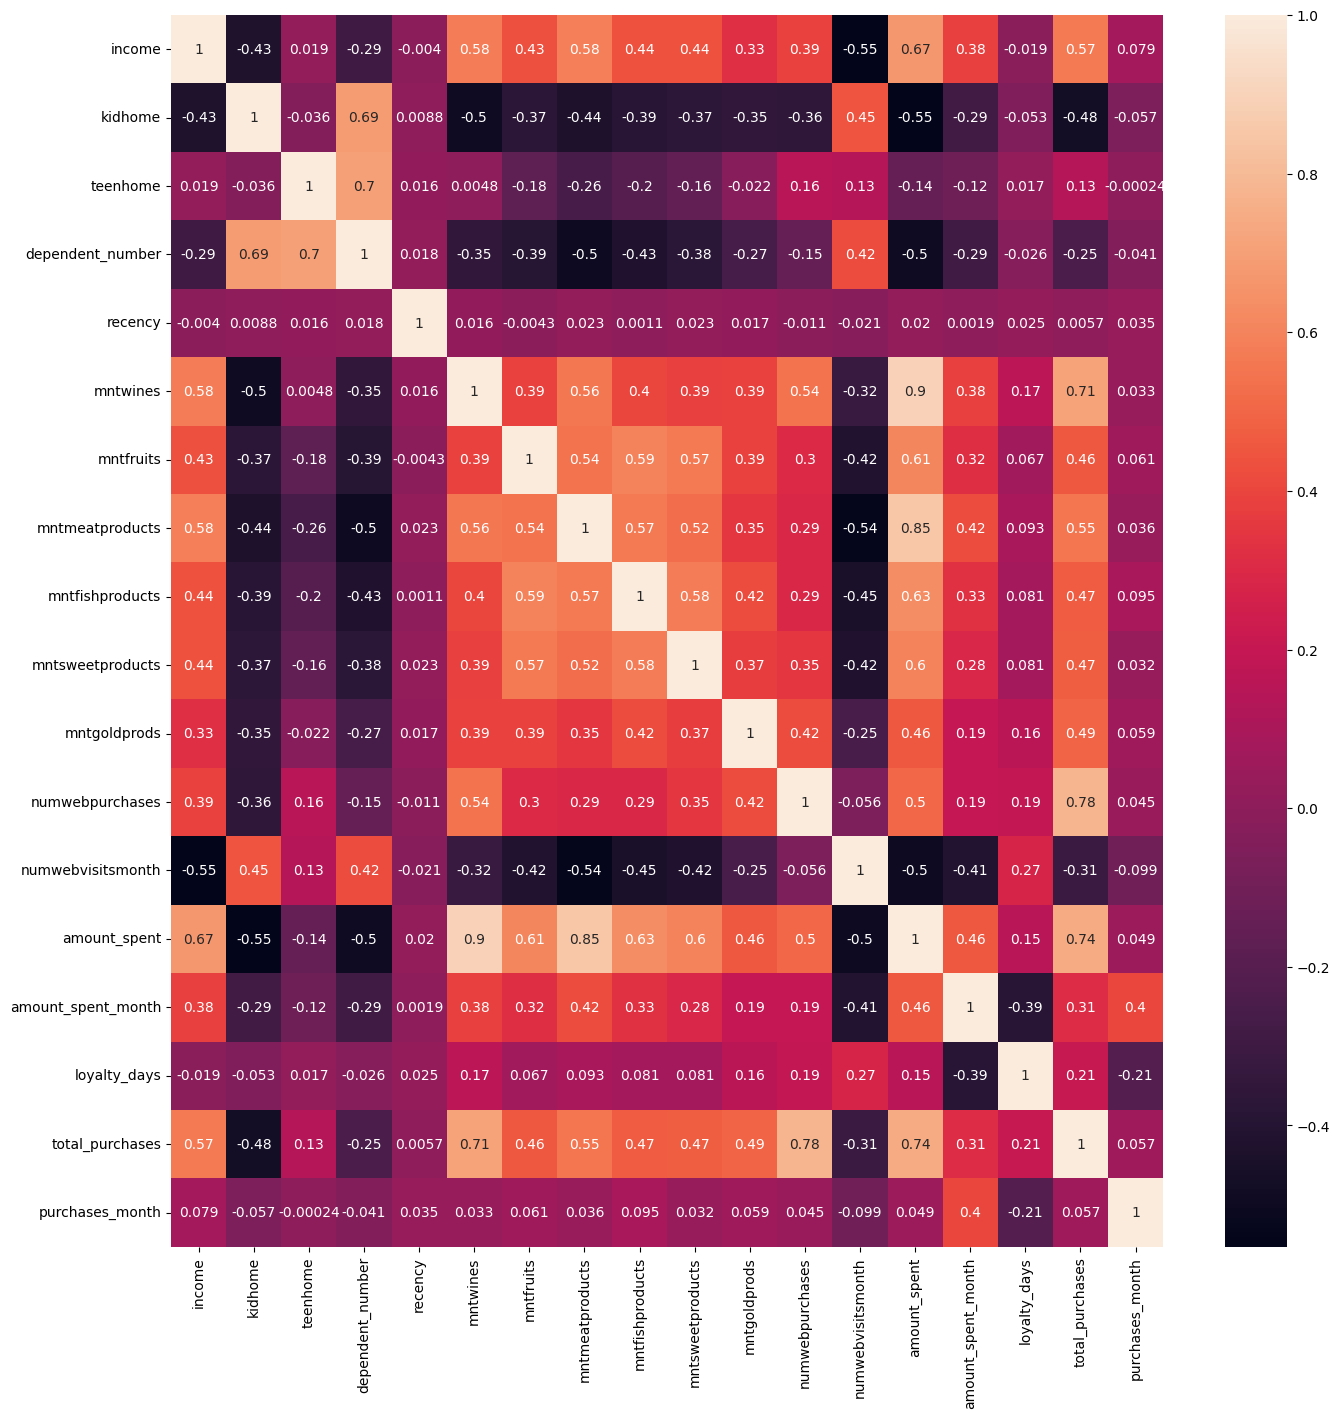

In [306]:
plt.figure(1, figsize=(16,16))
sns.heatmap(df4[['income','kidhome','teenhome','dependent_number', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts','mntgoldprods', 'numwebpurchases', 'numwebvisitsmonth', 'amount_spent','amount_spent_month', 'loyalty_days', 'total_purchases', 'purchases_month']].corr(), annot = True)

- numwebvisitsmonth shows almost 0 correlation, which doesn't make sense.
- the highest correlation for purchases on web are wine and gold products(0.54 and 0.42)


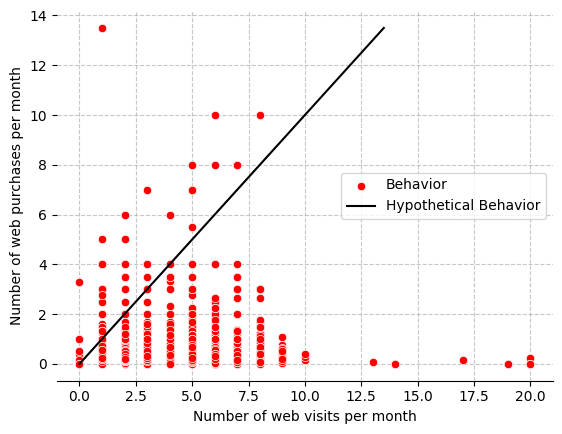

In [307]:
sns.scatterplot(x = 'numwebvisitsmonth', y = 'web_purchases_month', color = 'red',  data = df4, label = 'Behavior')
sns.lineplot(x = 'web_purchases_month', y = 'web_purchases_month', color = 'black', data = df4, label = 'Hypothetical Behavior')
plt.xlabel('Number of web visits per month')
plt.ylabel('Number of web purchases per month')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(False)

plt.rc('axes', axisbelow=True)
plt.grid(linestyle='--', alpha=0.7)


We can see a negative correlation between number of visits per month and number of web purchases. The meaning of this graphic is there are some clients that are visiting the web site, but they don't buy. With the data that we have, it is impossible to claim the why, but we can suppose that they are receiving the wrong offer, or they are searching several times for a product and they don't find.

If customers are above the line, it means that they are profitable and they are buying more than visting. Above the line, the website is not being efficient for these customers.

**What are the negative and positive characteristics of web sales?**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


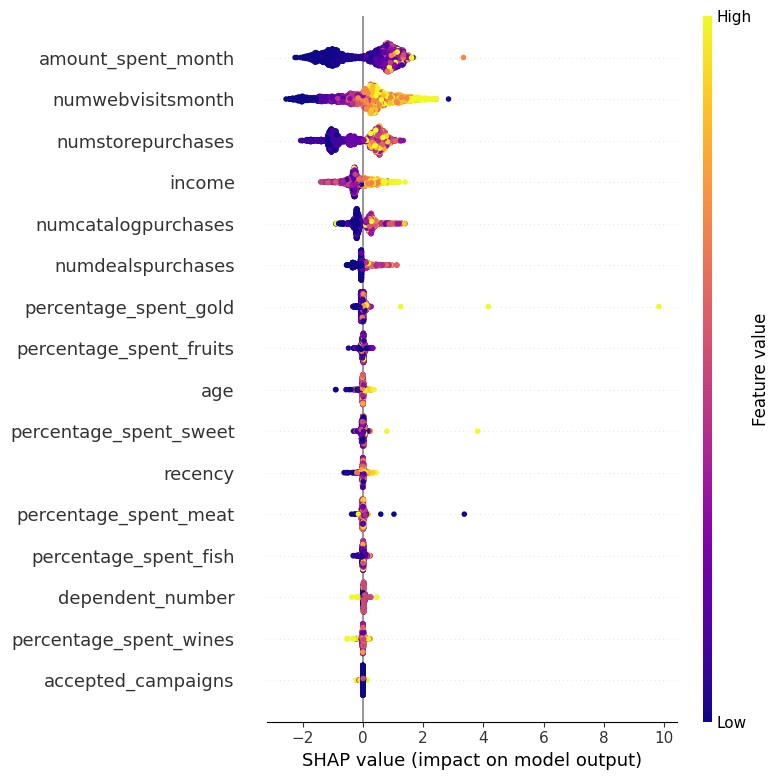

In [308]:
# Explain the web purchases
campaign = 'numwebpurchases'

features = ['income', 'dependent_number', 'amount_spent_month', 'accepted_campaigns', 'recency', 'percentage_spent_wines', 'percentage_spent_fruits', 'percentage_spent_meat', 'percentage_spent_sweet', 'percentage_spent_gold', 'percentage_spent_fish', 'numdealspurchases', 'numcatalogpurchases', 'numstorepurchases', 'age', 'numwebvisitsmonth']
df_rf = df4.copy().dropna()
X_train = df_rf[features]
y_train = df_rf[campaign]

# Run the model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Run the explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, cmap = "plasma")

- People that bought from Catalog or Store, also can know the brand and buy other items through the web channel.
- People that spend less tend to buy more online, which makes a good channel for low price products.
- The products that most impact the sales from web are: gold and sweet, but the impact of those features is not so relevant.


## Conclusions and Insights

Understanding  generally the customers:

- Despite married customers are in higher number on the platform, it is alone/divorced/single people that most accept marketing campaigns.
- Education seems to be a relevant factor to accept a campaign, since it's people with more education that accept more.
- People with more amount spent per month tend to accept more campaigns, but they purchase less than others.
- People who buy from catalog channel tend to accept more campaigns than others.


Analyzing behavior of customers that accept the best and the worst campaign:
- Best campaign is the last one, reaching 14.9% of conversion;
- Worst campaign is number 2, reaching 1.33 % of conversion;
- The avg conversion of a campaign is around 7.4 %;

Answering hypothesis:
- The new users arrive with the same distribution along the year?
    - Yes, most part of the year they follow the same pattern, however, June and July are the worst months.
- Which campaign has the best performance?
    - Last campaign, number 6 (response).
- There are differences between the best and the worst campaign with respect to the avg campaigns? 
    - Yes, there are many differences depicted in the 2 graphics above.
- What are the negative and positive characteristics of users that accept the marketing campaigns (2 and 6)?
    - What are the negative and positive characteristics of users that accept the marketing campaigns (2 and 6)?
    - numcatalogpurchases HIGH IMPACT FOR 2, HIGH IMPACT FOR 6
    - pct_spent_wines HIGH IMPACT FOR 2, LOW IMPACT FOR 6 => AVOID PEOPLE THAT SPEND ON WINE
    - income HIGH IMPACT FOR 2, HIGH IMPACT FOR 6 
    - amonth_spent_month HIGH IMPACT FOR 2, LOW IMPACT FOR 6 => AVOID PEOPLE THAT SPENT A LOT PER MONTH
    - pct_spent_meat LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE THAT SPEND ON MEAT
    - numstorepurchases HIGH IMPACT FOR 2, LOW IMPACT FOR 6 => AVOID PEOPLE WHO BUY FROM STORES
    - pct_spent_fruits LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE WHO SPENT MORE ON FRUITS
    - pct_spent_sweat LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE WHO SPENT MORE ON SWEAT
    - numwebpurchases LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE WHO SPENT MORE ON WEB
    - pct_spent_fish LOW IMPACT FOR 2, LOW IMPACT FOR 6
    - dependent number LOW IMPACT FOR 2, LOW IMPACT FOR 6
    - pct_spent_gold LOW IMPACT FOR 2, HIGH IMPACT FOR 6 => FOCUS ON PEOPLE WHO SPENT MORE ON GOLD PRODS
    - What channel brings more amount of money?
    - What are the negative and positive characteristics of web sales?
- What channel brings more amount of money?
    - The channel that is most correlated with amount spent is catalog.
- What are the negative and positive characteristics of web sales?
    - People spend less in web sales and usually they can know the website from a store purchase. Also, apparently is a good channel for gold products.


Insights:
- In the first moment, focus on campaigns using catalog and store channels and people who single people and with high income;
- Focus on campaign for meat products, but trying to focus on small prices;
- From March to May seems to be a good season to get new customers. The actions on June and July need to be improved to keep the attraction straight over the year;
- Web channel need to be improved to launch a marketing campaign and have more conversion. Campaigns for people who spend less and buy products tagged as "gold" and "sweat"  in this channel seems to be a good idea. Fish should be avoided;
- To improve conversion, it must be implemented a  customer segmentation to send better offers to the customers on web. Variables related to channel, amount_spent and products should be used;
- The user experience of the website must me checked, since we have a better UX, people will return and buy more.

